In [1]:
import os
import subprocess
import matplotlib.pyplot as plt

import scipy.stats as sps
from scipy import stats
import numpy as np
import pandas as pd
import pkg_resources
#pkg_resources.require("seaborn==0.11.0")
import seaborn as sns
import pylab
import random
from scipy.stats import qmc

import re
import array
from itertools import groupby


import os
import subprocess
import matplotlib.pyplot as plt

import scipy.stats as sps
from scipy import stats
import numpy as np
import pandas as pd
import pkg_resources
#pkg_resources.require("seaborn==0.11.0")
import seaborn as sns
import pylab
import random
from scipy.stats import qmc

import re
import array

from sympy import S
from sympy.physics.wigner import clebsch_gordan
from sympy.physics.wigner import racah
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
import numpy as np
from __future__ import division
import scipy as sci
import scipy.special as sp
from scipy.integrate import dblquad
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import qmc
import os
import datetime
import time
import scipy.stats as sps
from multiprocessing import Pool
from itertools import repeat
import random
import math
from scipy.integrate import odeint
from IPython.display import display, clear_output,set_matplotlib_formats
import matplotlib.cm as cm
import matplotlib.ticker
import matplotlib.mlab as mlab
import sys
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.special import spherical_jn, spherical_yn



import numpy as np
from scipy.integrate import tplquad

#plt.style.use('science')
plt.rcParams.update({'font.size': 12})
gr = 4
h = 3

In [2]:
os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

In [94]:
###constants
mass_nucleon = 931.5                 # MeV
hbarc = 197.327                      # MeV • fm
#####

###energies and mass
energy = 9.2307                      # C.O.M. MeV
energy_channel_2 = 4.80077           # C.O.M. MeV
mass_target = 12.00                  # nucleons
#####

###useful quantities
mass_coeff = mass_target**(1/3)      # A^(1/3)
reduced = (mass_target*mass_nucleon*mass_nucleon)/((mass_target+1)*mass_nucleon)
k = np.sqrt((2*reduced*energy)/(hbarc**2))
hbar2_mu = (hbarc**2)/(2*reduced)
fresco_check = 1/hbar2_mu*(13/12)
#####

###tolerances for normalization
tolerance = 1.0e-5
#####

#grid and numerical values
r = np.linspace(0.0,40.0,4001)      # radial grid
nruns = 100                         # number of training runs
sruns = 10                          # number of emulated solutions
number_basis = 14                   # number of SVD bases
drop = 4                            # values to drop at the end-points
######


### wave numbers
l_val = 0                           # wave number index (order from Fresco)       
r_val = 0                           # run number index (from the emulated solutions)
coupled_set_num =0                  # coupled channel set (order from Fresco, the J_tot value) 
#####



In [4]:
def F(rho, ell):
    '''
    Bessel function of the first kind.
    '''
    return rho*spherical_jn(ell, rho)


def G(rho, ell):
    '''
    Bessel function of the second kind.
    '''
    return -rho*spherical_yn(ell, rho)


def H_plus(rho, ell):
    '''
    Hankel function of the first kind.
    '''
    return G(rho, ell) + 1j*F(rho, ell)


def H_minus(rho, ell):
    '''
    Hankel function of the second kind.
    '''
    return G(rho, ell) - 1j*F(rho, ell)


def H_plus_prime(rho, ell, dx=1e-6):
    '''
    Derivative of the Hankel function (first kind) with respect to rho.
    '''
    return derivative(lambda z: H_plus(z, ell), rho, dx=dx)


def H_minus_prime(rho, ell, dx=1e-6):
    '''
    Derivative of the Hankel function (second kind) with respect to rho.
    '''
    return derivative(lambda z: H_minus(z, ell), rho, dx=dx)


def phi_free(rho, ell):
    '''
    Solution to the "free" (V = 0) radial Schrödinger equation.
    '''
    return (H_plus(rho, ell) - H_minus(rho, ell))


# def phase_shift(u, up, ell, x0):
#     rl = 1/x0 * (u/up)
#     return np.log(
#         (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) / 
#         (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
#     ) / 2j


def phase_shift(phi, phi_prime, ell, x0):
    rl = 1/x0 * (phi/phi_prime)
    return np.log(
        (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) / 
        (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
    ) / 2j


#def phase_shift_interp(u, s, ell, x0, dx=1e-6):
#    '''
#    Given the solution, u, on the s grid, return the phase shift (with respect to the free solution).
#    '''
#    u_func = interp1d(s, u, kind='cubic')
#    rl = 1/x0 * (u_func(x0)/derivative(u_func, x0, dx=dx))
#    return np.log(
#        (H_minus(x0, ell) - x0*rl*H_minus_prime(x0, ell)) / 
#        (H_plus(x0, ell) - x0*rl*H_plus_prime(x0, ell))
 #   ) / 2j
    
def phase_shift_interp(u, s, ell, x0, dx=1e-6):
    '''
    Given the solution, u, on the s grid, return the phase shift (with respect to the free solution).
    '''
    u_func = interp1d(s, u, kind='linear')  # Use linear interpolation for potential optimization
    rl = 1 / x0 * (u_func(x0) / derivative(u_func, x0, dx=dx))
    
    # Precompute constants
    h_minus = H_minus(x0, ell)
    h_minus_prime = H_minus_prime(x0, ell)
    h_plus = H_plus(x0, ell)
    h_plus_prime = H_plus_prime(x0, ell)
    
    # Compute the phase shift
    log_term = (h_minus - x0 * rl * h_minus_prime) / (h_plus - x0 * rl * h_plus_prime)
    return np.log(log_term) / 2j

def generate_second_derivative_matrix_9point(xgrid):
    '''
    For a given grid of points, compute the second derivative in 9 points
    '''
    N = len(xgrid)
    dx = xgrid[1] - xgrid[0]

    # Generate the matrix for the second derivative using a seven-point stencil
    main_diag = np.ones(N) * (-205.0 / 72.0 / dx**2)
    off_diag = np.ones(N - 1) * (8.0 / 5.0 / dx**2)
    off_diag2 = np.ones(N - 2) * (-1.0/ 5.0 / dx**2)
    off_diag3 = np.ones(N - 3) * (8.0 / 315.0 / dx**2)
    off_diag4 = np.ones(N - 4) * (-1.0 / 560.0 / dx**2)

    D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2) + np.diag(off_diag3, k=3) + np.diag(off_diag3, k=-3) + np.diag(off_diag4, k=4) + np.diag(off_diag4, k=-4) 
    
    # One-sided approximations near boundaries
    D2[0, :9] = np.array([29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[1, :10] = np.array([0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[2, :11] = np.array([0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[3, :12] = np.array([0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[4, :13] = np.array([0.0, 0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[5, :14] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[6, :15] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2
    D2[7, :16] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29531/5040, -962/35, 621/10, -4006/45, 691/8, -282/5, 2143/90, -206/35, 363/560]) / dx**2

    
    return D2


##now lets add the centrifugal part of the potential
def centrifugal(l,x):
    '''with a radia grid x, generate an array containing the centrifugal potential'''
        
    if x[0] == 0:
        x[0] = 1
        cent = (l*(l+1))/(x**2)
        cent[0] = 0.0
        x[0] = 0
        #print(cent)
    
    else:
        cent = (l*(l+1))/(x**2)
    
    return cent

In [5]:
def latin_sampling_3(samples):
    
    '''Given a number of samples, generate a parameter array.'''
    
    #n_train = 50
    
    random.seed(142857)

    
    Vv0 = 51.8

    Rv0 = 1.17

    av0 = 0.75
    
    ## Central value of parameter values
    alphaCentral = np.array([Vv0, Rv0, av0])


    #Creating a scale for how much the parameters will wiggle. Afterwards we sample from a latin hyper cube for training,
    #but use this scales also for the testing sampling which we do it with a Gaussian
    scaleTraining=0.3

    bounds_Vv_Scale = abs(Vv0*(scaleTraining))

    bounds_Rv_Scale = abs(Rv0*(scaleTraining))

    bounds_av_Scale = abs(av0*(scaleTraining))

    bounds_alpha=[bounds_Vv_Scale,bounds_Rv_Scale,bounds_av_Scale]
    
    bounds_Vv = [Vv0-bounds_Vv_Scale, Vv0+bounds_Vv_Scale]

    bounds_Rv = [Rv0-bounds_Rv_Scale, Rv0+bounds_Rv_Scale]

    bounds_av = [av0-bounds_av_Scale, av0+bounds_av_Scale]


    ## Bound array of the latin hypercube, min and max of the cube array in the form 
    ## array = [[V_min,V_max],[r_min,r_max],..]
    ##dim= (7,2)
    bounds = np.array([
    
        bounds_Vv,
        bounds_Rv,
        bounds_av,
    
    ])

    #random sampling inside the cube and creates the training potential array
    sampler = qmc.LatinHypercube(d=len(bounds))
    #sample = sampler.random(n_train)

    ## This is the array of (50,7) with the correct parameters. 
    ## This is important!!!!
    #train = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

    #potential empirical interpolation method, number of training parameters
    #n_train_EIM=1000
    random.seed(142857)
    sample_EIM = sampler.random(samples)
    ## training set parameters for the optica potential emulator
    train_EIM = qmc.scale(sample_EIM, bounds[:, 0], bounds[:, 1])
    
    return train_EIM

In [6]:
def generate_input_file_inelastic(parameter_values):
    '''
    given a parameter array, pass the parameters and rewrite the Frescox input file
    '''
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
    file = 'frescox_inputs/12C_n_ine_template.in'

    with open(file) as f:
        content = f.readlines()
        
    no_p = 0;
    for idx, line in enumerate(content):
        if 'XXXXX' in line:
            no_param = line.count('XXXXX')
            line_temp = line
            for i in range(no_param):
                line_temp = line_temp.replace("XXXXX", str(parameter_values[no_p]), 1) 
                no_p += 1
    
            content[idx] = line_temp
    
    f = open("frescox_inputs/frescox_ine_temp_input.in", "a")
    f.writelines(content)
    f.close()
    
    
def extract_partial_waves(file_extract='fort.17'):
    '''
    this code extracts from the fort.17 file the partial waves and adds them as dictionary with the keys
    corresponding to the different quantum numbers of the coupled set of differential equations. The keys are
    broken down as follows {coupled channel set,channel number,l',j',J, l, j}.
    '''
    keys_array = []
    
    # Initialize a dictionary to store the values
    data_dict = {}

    # Initialize a counter for lines starting with "401"
    count_401 = 0

    # Specify the file path
    file_path = 'fort.17'

    # Regular expression pattern to match lines with the desired format
    pattern = re.compile(r'^\s*(\d+\s+\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\s+\d+\.\d+)')
    
    pattern2 = re.compile(r'^\s*201\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+-1\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+')

    pattern3 = re.compile(r'^\s*-1\s+0\s+0\.0\s+0\.0\s+0\s+0\.0\s+0\.0{10}\s+0\.0{10}\s+0\.0{8}')

    # Open the file and read its contents
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Initialize a variable to hold the current key
    current_key = None

    # Iterate through the lines to find lines that match the pattern
    for i in range(len(lines)):
        line = lines[i].strip()
        match = pattern.match(line)
        if match:
            # Convert the first 6 values of the line to floats and use them as part of the key
            key_values = match.group(1).split()[:6]
            key_values = [float(value) for value in key_values]
            current_key = tuple([count_401] + key_values)
            # Initialize an empty list for the values associated with the key
            data_dict[current_key] = []
            i += 1  # Move to the next line to start reading values
            while i < len(lines)  and not lines[i].startswith("4001"):
                # Split the current line into values
                line2 = lines[i].strip()
                match2 = pattern.match(line2)
                line4 = lines[i].strip()
                match4 = pattern3.match(line2)
                if match2:
                    break
                if match4:
                      i+=1
                else:
                    values = lines[i].split()
                    # Convert values to floats and append them to the current key's list
                    data_dict[current_key].extend([float(value.replace('D', 'E')) for value in values])
                    i += 1
        elif lines[i].startswith("4001"):
            # Increment the counter for lines starting with "401"
            count_401 += 1
    
    keys_array = list(data_dict.keys())
  
    
    return data_dict, keys_array


def wave_functions_format_imaginary(file_extract='fort.17'):
    '''
    This function takes as input the fort.17 file and using the keys from the function extract_partial_waves
    then writes the wavefunction from the fresco output to \psi= real + imag
    '''
    waves_exact = {}
    
    data_dict, keys_array = extract_partial_waves()
    
    for key in keys_array:
        temp_real_array = []
        temp_imag_array = []
        temp_wave = data_dict.get(key)
        for i in range(len(np.array(temp_wave))):
            radial = temp_wave[i]
            if (i % 2 != 0):
                temp_imag_array.append(radial)
            if (i % 2 == 0) :
                temp_real_array.append(radial)
                
        waves_exact[key] = np.array(temp_real_array) + 1j* np.array(temp_imag_array)
        
        
    return waves_exact, keys_array



def frescox_output_inelastic_wavefunctions(input_file='frescox_inputs/frescox_ine_temp_input.in',
                   output_file='fort.17'):
    '''
    this function reads in the frescox input file formatted through the generated input file function
    runs it and extracts the partial wave functions with the respective keys corresponding to the quantum
    numbers.
    '''

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_ine_temp_input.in > frescox_outputs/test_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    waves, keys = wave_functions_format_imaginary(output_file)
    
        
    os.remove(input_file)
    os.remove(output_file)
    
    return waves, keys

def frescox_run_inelastic_waves(theta):
    '''
    This function takes as an input a set of parameters and for each parameter set generates a frescox
    input using the template form, and then runs frescox and extracts the wave functions. the outputs 
    are an array whose elements are dictionaries of the different partial waves corresponding to
    each set of paramters in theta, and the keys to the dictionaries.
    '''
    theta_list = theta.tolist()
    waves_array = []
#    keys_array = []
    for para_obs in theta_list:
        #para_obs += [3.5,1,0.3]
        generate_input_file_inelastic(para_obs)
        waves_per_calc, keys_per_calc  = frescox_output_inelastic_wavefunctions()
        waves_array.append(waves_per_calc)
#        keys_array.append(keys_per_calc)

    return waves_array, keys_per_calc

def frescox_output_inelastic_wavefunctions_free(input_file='frescox_inputs/12C_n_free.in'):
    '''
    this function reads in the frescox input file formatted through the generated input file function
    runs it and extracts the partial wave functions with the respective keys corresponding to the quantum
    numbers.
    '''

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/12C_n_free.in > frescox_outputs/12C_n_free.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)
    
    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    waves, keys = wave_functions_format_imaginary('fort.17')
    
        
    
    return waves, keys

def frescox_run_inelastic_waves_free():
    '''
    This function extracts the free solutions (all parameters are set to zero). The outputs 
    are a dictionary whose elements are the different free partial waves and a set of keys to extract the free
    waves.
    '''
    waves_per_calc, keys_per_calc  = frescox_output_inelastic_wavefunctions_free()

    return waves_per_calc, keys_per_calc

In [7]:
# generate training and solving arrays
theta_tr = latin_sampling_3(nruns)
theta_solve = latin_sampling_3(sruns)

In [8]:
a_comp,b_comp = frescox_run_inelastic_waves(theta_tr)

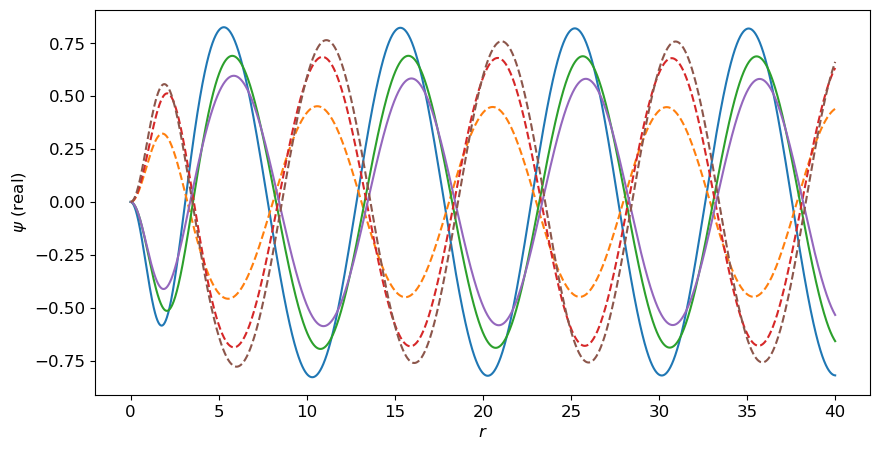

In [9]:
#extract some frescox wavefunctions and plot to see what they look like.
wave_set = []
for i in range(len(a_comp)):
    wave_keyed = a_comp[i].get(b_comp[2])
    wave_set.append(wave_keyed)
#print(np.shape(wave_set))

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(3):
    ax.plot(r, np.real(wave_set[i]), zorder=1,label='real')
    ax.plot(r, np.imag(wave_set[i]), zorder=1,linestyle='--',label='imag')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$ (real)')
#ax.set_yscale('log')
pylab.show()

In [10]:
def group_channels(keys):
    '''
    groups the keys by channel number to normalize and cast into galerkin formulation
    '''
    quantum_numbers = keys
    
    # Sort the list based on the first element of each tuple (channel set)
    quantum_numbers.sort(key=lambda x: x[0])
    # Group the tuples by the first element (channel set)
    g_quantum_numbers = {key: list(group) for key, group in groupby(quantum_numbers, key=lambda x: x[0])}
    
    return g_quantum_numbers

def Gamow_factor(l, eta):
    r'''This returns the... Gamow factor.
    See [Wikipedia](https://en.wikipedia.org/wiki/Gamow_factor).

    Parameters:
        l (int): angular momentum
        eta (float): Sommerfeld parameter (see
            [Wikipedia](https://en.wikipedia.org/wiki/Sommerfeld_parameter))
    
    Returns:
        C_l (float): Gamow factor

    '''
    if eta == 0.0:
        if l == 0:
            return 1
        else:
            return 1 / (2*l + 1) * Gamow_factor(l-1, 0)
    elif l == 0:
        return np.sqrt(2*np.pi*eta / (np.exp(2*np.pi*eta)-1))
    else:
        return np.sqrt(l**2 + eta**2) / (l*(2*l+1)) * Gamow_factor(l-1, eta)



def find_smallest_nonzero(wave,l):
    '''
    given an array, it finds the smallest value matchin the r0 condition bellow starting from the beginning. 
    this will ensure we do not divide by 0.
    '''
    i = 0
    gamow = Gamow_factor(l,0)
    while np.abs(gamow*(r[i])**(l+1)) <= tolerance: ##condition
        i += 1
        minimum = wave[i]
        a = i
        #print(i)
    return minimum, a

def rescaling_function_free(wave,keys,l):
    '''
    normalizes the wave near zero in this manner: 
    psi' = C_l*psi*r0^(l+1)/psi(r0) for free solutions only!
    '''
    mini, i0 = find_smallest_nonzero(wave.get(keys[l]),l)
    wave_res = []
    w_keyed = Gamow_factor(l,0)*((r[i0])**(l+1))*(wave.get(keys[l]))/(wave.get(keys[l]))[i0]
    return np.array(w_keyed)

def rescaling_function_factor(wave,l):
    '''
    normalizes the wave near zero in this manner: 
    psi' = C_l*psi*r0^(l+1)/psi(r0)
    '''
    mini, i0 = find_smallest_nonzero(wave,l)
    wave_res = []
    
    w_keyed = (Gamow_factor(l,0)*((r[i0])**(l+1))*(wave))/((wave)[i0])
    
    factor = (Gamow_factor(l,0)*((r[i0])**(l+1)))/((wave)[i0])
    
    return np.array(w_keyed), factor

def frescox_run_inelastic_rescaled_waves(theta,xgrid):
    '''
    This function takes as an input a set of parameters and for each parameter set generates a frescox
    input using the template form, and then runs frescox and extracts the wave functions. the outputs 
    are an array whose elements are dictionaries of the different partial waves corresponding to
    each set of paramters in theta, and the keys to the dictionaries. It then passes them through the appropriate
    rescaling functions above, this function normalizes the elastic and passes the same normalization
    to the inelastic channels in the same coupled channel set.
    '''
    waves, keys = frescox_run_inelastic_waves(theta)
    free_waves, free_keys = frescox_run_inelastic_waves_free()
    grouped_channels = group_channels(keys)
    
    wave_scaled_dict = {}
    
    wave_set_free = []
    for j in range(len(free_keys)):
        l = int(free_keys[j][2])
        wave_free_keyed = rescaling_function_free(free_waves, free_keys, l)
        wave_set_free.append(wave_free_keyed)
    

    
    for m in (grouped_channels):
        subset_channels = grouped_channels.get(m)
        #print(subset_channels[0][2])
        
        for j in range(len(subset_channels)):
            l = int(subset_channels[j][2])
            wave_set = []
            
                
            if (subset_channels[j][1])==1.0:
                for i in range(len(waves)):
                    wave_unscaled = waves[i].get(subset_channels[j])
                    wave_scaled, factor = rescaling_function_factor(wave_unscaled,l)
                    #print(factor,i,l)
                    wave_set.append(wave_scaled)   
                
                
            else:
                for i in range(len(waves)):
                    wave_unscaled = waves[i].get(subset_channels[j])
                    wave_scaled, factor = rescaling_function_factor(waves[i].get(subset_channels[0]),int(subset_channels[0][2]))
                    #print(factor,i,l)
                    wave_set.append(np.array(wave_unscaled)*factor)

                
            wave_scaled_dict[subset_channels[j]] = np.array(wave_set)

            
    return wave_scaled_dict, keys

In [11]:
a_comp_rescaled,b_comp_rescaled = frescox_run_inelastic_rescaled_waves(theta_tr,r)

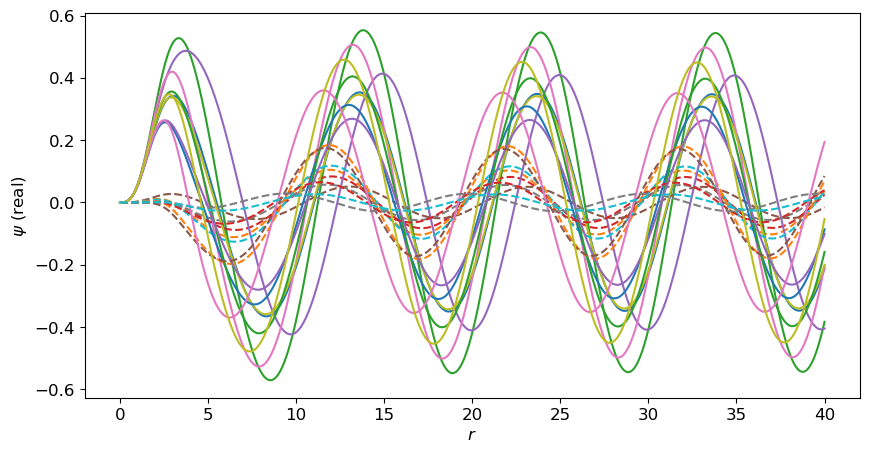

In [16]:
#extract some frescox wavefunctions and plot to see what they look like.
wave_set = []
for i in range(nruns):
    wave_keyed = a_comp_rescaled.get(b_comp_rescaled[5])[i] 
    wave_set.append(wave_keyed)
#print(np.shape(wave_set))

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(10):
    ax.plot(r, np.real(wave_set[i]), zorder=1,label='real')
    ax.plot(r, np.imag(wave_set[i]), zorder=1,linestyle='--',label='imag')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$ (real)')
#plt.xlim(0,1)
#ax.set_yscale('log')
pylab.show()

In [95]:
def from_runs_SVD_extract_frescox_asymp(waves,keys,nbasis,xgrid, run_num):
    '''
    This function generates the SVD components from the data of exact solutions.
    I takes as input a dictionary of rescaled waves, the keys of the dictionary, the user-defined
    number of bases, the radial grid of the solutions and the number of data runs. It then subtracts the
    corresponding free solutions from all the elastic channels. The SVD components are calculated
    after this subtraction.Outputs are the SVDs, the second derivative of the SVDs, the rescaled
    free solutions and their second derivatives, the grouped keys array, the second derivative matrix
    and the singular values.
    '''
    free_waves, free_keys = frescox_run_inelastic_waves_free()
    D2 = generate_second_derivative_matrix_9point(xgrid)
    grouped_channels = group_channels(keys)

    SVD_per_channel = {}
    SVD_per_channel_d2 = {}
    free_phi0 = {}
    free_d2 = {}
    singular_values = []

    wave_set_free = []
    for j in range(len(free_keys)):
        l = int(free_keys[j][2])
        wave_free_keyed = rescaling_function_free(free_waves, free_keys, l)
        wave_set_free.append(wave_free_keyed)



    for m in (grouped_channels):
        subset_channels = grouped_channels.get(m)
        
        for j in range(len(subset_channels)):
            #print(j)
            l = int(subset_channels[j][2])
            wave_set = []
            
            if (subset_channels[j][1])==1.0:
                for i in range(run_num):
                    wave_scaled = waves.get(subset_channels[j])[i]
                    wave_set.append(wave_scaled)
                phi0 = wave_set_free[l]
                #print(phi0,l,subset_channels[j])
                np_wave_set = (np.array(wave_set) - phi0).T
                print(np.shape(np_wave_set))
                U, S, Vt = np.linalg.svd(np_wave_set, full_matrices=False)
                basis = U[:, :nbasis]
                singular_values.append(S[:nbasis])
                d2 = D2@basis
                d20 = D2@phi0
                SVD_per_channel[subset_channels[j]] = basis
                SVD_per_channel_d2[subset_channels[j]] = d2
                free_d2[(l)] = D2 @ wave_set_free[l]
                free_phi0[(l)]=wave_set_free[l]
                print(np.shape(basis),'el')
            
            else:
                for i in range(run_num):
                    wave_scaled = waves.get(subset_channels[j])[i]
                    wave_set.append(wave_scaled)
                np_wave_set = (np.array(wave_set)).T
                print(np.shape(np_wave_set))
                U, S, Vt = np.linalg.svd(np_wave_set, full_matrices=False)
                basis = U[:, :nbasis]
                singular_values.append(S[:nbasis])
                d2 = D2@basis
                SVD_per_channel[subset_channels[j]] = basis
                SVD_per_channel_d2[subset_channels[j]] = d2
                #print(np.shape(basis))
                print(np.shape(basis),'in')
                

    return SVD_per_channel, SVD_per_channel_d2,free_phi0, free_d2, grouped_channels, D2, singular_values

In [96]:
SVD,SVD_d2,free_waves,free_waves_d2,groups,D2,sing_vals = from_runs_SVD_extract_frescox_asymp(a_comp_rescaled,b_comp_rescaled, number_basis,r, nruns)

(4001, 100)
(4001, 14) el
(4001, 100)
(4001, 14) in
(4001, 100)
(4001, 14) el
(4001, 100)
(4001, 14) in
(4001, 100)
(4001, 14) in
(4001, 100)
(4001, 14) el
(4001, 100)
(4001, 14) in
(4001, 100)
(4001, 14) in
(4001, 100)
(4001, 14) in
(4001, 100)
(4001, 14) el
(4001, 100)
(4001, 14) in
(4001, 100)
(4001, 14) in
(4001, 100)
(4001, 14) in


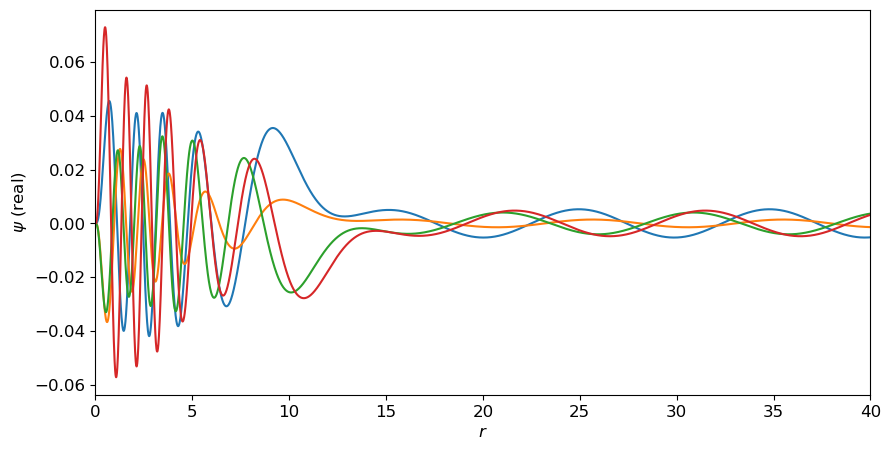

In [97]:
# Observe SVD outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(10,14):
    ax.plot(r, SVD.get(b_comp_rescaled[0]).T[i].real, zorder=1,label='real')
    #ax.plot(r, SVD.get(b_comp_rescaled[1]).T[i].real, zorder=1,linestyle='--',label='imag')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$ (real)')
plt.xlim(0,40)
#ax.set_yscale('log')
pylab.show()

In [98]:
def frescox_output_inelastic_wavefunctions_potential(input_file='frescox_inputs/frescox_ine_temp_input.in',
                   output_file1='fort.17',output_file2='fort.34'):
    '''
    this function reads in the frescox input file formatted through the generated input file function
    runs it and extracts the partial wave functions with the respective keys corresponding to the quantum
    numbers.
    '''

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_ine_temp_input.in > frescox_outputs/test_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    waves, keys = wave_functions_format_imaginary(output_file1)
    potential = extract_deformed_potential(output_file2)
    
        
    os.remove(input_file)
    os.remove(output_file1)
    os.remove(output_file2)
    
    return waves, keys, potential

def frescox_run_inelastic_waves_potential(theta):
    '''
    This function takes as an input a set of parameters and for each parameter set generates a frescox
    input using the template form, and then runs frescox and extracts the wave functions. the outputs 
    are an array whose elements are dictionaries of the different partial waves corresponding to
    each set of paramters in theta, and the keys to the dictionaries.
    '''
    theta_list = theta.tolist()
    waves_array = []
    potential_array = []
    for para_obs in theta_list:
        #para_obs += [3.5,1,0.3]
        generate_input_file_inelastic(para_obs)
        waves_per_calc, keys_per_calc, potential_per_calc  = frescox_output_inelastic_wavefunctions_potential()
        waves_array.append(waves_per_calc)
        potential_array.append(potential_per_calc)

    return waves_array, keys_per_calc, potential_array

def extract_deformed_potential(file_path='fort.34'):
    '''
    this code extracts from the fort.39 file the partial waves and adds them as dictionary with the keys
    corresponding to the different quantum numbers of the coupled set of differential equations. The keys are
    broken down as follows {coupled channel set,channel number,l',j',J, l, j}.
    '''
    data = {}

    with open(file_path, 'r') as file:
        current_case = None
        current_r = []
        current_v = []

        for line in file:
            if line.startswith('# Potential'):
                # Extracting case information
                case_info = line.split()
                current_case = int(case_info[3].strip(':'))
                current_r = []
                current_v = []
                data[current_case] = {'R': current_r, 'V': current_v}
            elif line.strip() and not line.startswith('&'):
                # Extracting R and V values
                values = line.split()
                if len(values) >= 2:
                    r = float(values[0])
                    v = float(values[1])
                    current_r.append(r)
                    current_v.append(v)
                    
    return data

In [99]:
a_comp_potential, b_comp_potential, c_comp_potential = frescox_run_inelastic_waves_potential(theta_solve)

In [100]:
def hat(a):
    '''
    Just a function to compute normalzation coefficients of the Wigner-Eckhart theorem
    '''
    return np.sqrt(2*a+1)


def total_coupling_test(I_i, l_i, j_i, I_f, l_f, j_f, s, J, Q):
    '''
    Given the quantum numbers of one specific choice of initial and final channels calculate the coupling
    coefficient.
    '''
    K_f = 0
    K_i = 0
#     coeff = (-1)**(Q+s+K_f+(2*j_i)+J)*hat(l_i)*hat(l_f)*hat(j_i)*hat(j_f)*hat(I_i)*hat(I_f)*hat(Q) \
#           * wigner_6j(j_f,j_i,Q,I_i,I_f,J).n(12)*wigner_6j(j_f,j_i,Q,l_i,l_f,s).n(12) \
#             *wigner_3j(l_i,l_f,Q,0,0,0).n(12)*wigner_3j(I_i,I_f,Q,K_i,-K_f,0).n(12)
    if l_i==l_f:
        coeff = (-1)**(Q+J+l_i+I_f)*hat(I_i)*hat(l_i)*hat(Q) \
               * wigner_6j(l_i,I_i,J,I_f,l_f,Q).n(8) *clebsch_gordan(l_i,Q,l_f,0,0,0).n(8)\
               *clebsch_gordan(I_i,Q,I_f,K_i,0,K_f).n(8)
    else:
        coeff = (-1)**(Q+J+l_i+I_f+1)*hat(I_i)*hat(l_i)*hat(Q) \
               * wigner_6j(l_i,I_i,J,I_f,l_f,Q).n(8) *clebsch_gordan(l_i,Q,l_f,0,0,0).n(8)\
               *clebsch_gordan(I_i,Q,I_f,K_i,0,K_f).n(8)
    
    
    return coeff

def coupling_matrix(grouped_dict, spin, Q):
    '''
    Given a specific "grouped" coupled channel set, projectile spin and coupling potential order,
    calculate the coupling matrix elements between all channels in the coupled channel set. 
    '''
    group_coeff = {}
    
    for m in grouped_dict:
        sub_channel = grouped_dict.get(m)
        couplings = np.zeros((len(sub_channel), len(sub_channel)))
        
        for i in range(len(sub_channel)):
            I_initial = 0 if sub_channel[i][1] == 1 else 2
            
            for j in range(len(sub_channel)):
                I_final = 0 if sub_channel[j][1] == 1 else 2
                l_initial = sub_channel[i][2]
                j_initial = sub_channel[i][3]
                J_tot = sub_channel[i][4]
                l_final = sub_channel[j][2]
                j_final = sub_channel[j][3]
                
                coeff = total_coupling_test(I_initial, l_initial, j_initial, I_final, l_final, j_final, spin, J_tot, Q)
                couplings[i][j] = coeff
            
        group_coeff[m] = couplings
            
    return group_coeff

def generate_single_channel_operator(SVD_ar, SVD_d2_ar, l_val, monopole, E_channel, x):
    '''
    For a given SVD wave array, l value, monopole deformation, channel energy and radial grid,
    generate the single channel operator. 
    '''
    F_0 = - hbar2_mu*SVD_d2_ar + hbar2_mu*centrifugal(l_val,x)*SVD_ar + monopole*SVD_ar \
          - E_channel*SVD_ar
    
    return F_0


def generate_potetial_coupling(SVD_ar, potential, matrix_element):
    '''
    For a given SVD wave array, potential and numerical matrix element entry, generate the 
    coupling coupled channel operator, U_{ij}\psi_j.
    '''
    F_i = matrix_element*potential*SVD_ar
    
    return F_i

def phi0_couplings(f_dict,f_d2_dict,svd_dict,subsets_arr,mono,quad,matrix_el_sub,energy_el,x):
    
    '''
    
    '''
    
    free_solution_right = []
    
    l_0 = int(subsets_arr[0][2])
    phi0 = f_dict.get(l_0)[drop:-drop]
    d20 = f_d2_dict.get(l_0)[drop:-drop]
    F_0 = generate_single_channel_operator(phi0, d20, l_0, mono, energy_el, x)
    psi1_F_0 = svd_dict.get(subsets_arr[0])[drop:-drop].T @ F_0
    #free_solution_right.append(psi1_F_0)
    for v in range(len(subsets_arr)):
        if v == 0:
            psiv_coupling = svd_dict.get(subsets_arr[v])[drop:-drop].T @ generate_potetial_coupling(phi0, quad, matrix_el_sub[v][0])
            free_solution_right.append(psiv_coupling + psi1_F_0)
        else:
            psiv_coupling = svd_dict.get(subsets_arr[v])[drop:-drop].T @ generate_potetial_coupling(phi0, quad, matrix_el_sub[v][0])
            free_solution_right.append(psiv_coupling)
            #print(matrix_el_sub)
        
    return free_solution_right

In [101]:
def vector_channel_sum(v1, v2, subsets, free_dict):
    '''
    Given two vectors, in particular the concatenated Galerkin coefficients and the concatenated
    Galerkin bases, split them into len(subsets) vectors, the number of channels in a coupled channel set
    and do a dot product of each individual splitted vector to obtain the emulated solution. 
    For the elastic channel, add the free solutions. This function is used once for each coupled channel set, 
    after solving the constraint equations.
    '''
    split_array = []
    
    emulated_channels = {}
    
    split_v1 = np.split(v1,len(subsets))
    split_v2 = np.split(v2,len(subsets))
    #print(len(subsets))
    #print(np.shape(split_v2))
    #print(np.shape(split_v2))


    
    for h in range(len(subsets)):
        l_scaling = int(subsets[h][2])
        
        if int(subsets[h][1]) == 1:
            phi0_res = free_dict.get(l_scaling)[drop:-drop]
            emu_split = np.sum(split_v1[h]*split_v2[h].T,axis=1)
            #emu_scaled, factor = rescaling_function_factor(emu_split,l_scaling)
            emu = (emu_split + 1*phi0_res)
        else:
            emu_split = np.sum(split_v1[h]*split_v2[h].T,axis=1)
            #emu_scaled, factor = rescaling_function_factor(np.sum(split_v1[0]*split_v2[0].T,axis=1),int(subsets[0][2]))
            emu = (np.array(emu_split))
        
        emulated_channels[subsets[h]] = emu
        #print(subsets[h])
        
    return emulated_channels

In [102]:
def coupled_channels_emulator(SVD_dict, SVD_D2_dict, free_dict, free_d2_dict, grouped_dict,
                              spin, moment, energy_array, fresco_pot_array,radial_array, nbasis):
    '''
    Solve the Galerkin equations after the off-line stage. Only dictionary inputs are used. The interaction is 
    obtained from Frescox and each coupled channel set is solved simultaneously by concatenating each 
    set of bases in the coupled channel set. The vector_channel_sum function is then called to split and obtain
    solutions for each individual channel in the coupled channel set.
    '''
    r_array = radial_array[drop:-drop]
    energy_elastic, energy_inelastic = energy_array
    matrix_elements = coupling_matrix(grouped_dict, spin, moment)
    total_channels = []
    
    for f in range(len(fresco_pot_array)):
        V_mono = np.array(fresco_pot_array[f].get(2).get('V'))[drop:-(drop+1)]
        V_quad = np.array(fresco_pot_array[f].get(3).get('V'))[drop:-(drop+1)]
        #emulated_channels = {}
        channels_per_run = []
    
        for m in grouped_dict:
            emulated_subchannels = {}
            #free_solution_right = []
            basis_operators_tot = []
            psi = []
            
            subsets = grouped_dict.get(m)
            matrix_subset = matrix_elements.get(m)
            
            free_solution_right = phi0_couplings(free_dict,free_d2_dict,
                                                 SVD_dict,subsets,V_mono,V_quad,matrix_subset,
                                                 energy_elastic,r_array)
            

            for j in range(len(subsets)):
                operators = []
                wave1 = (SVD_dict.get(subsets[j])[drop:-drop].T)
                wave1_d2 = (SVD_D2_dict.get(subsets[j])[drop:-drop].T)
                l = int(subsets[j][2])
                if int(subsets[j][1]) == 1:
                    energy = energy_elastic 
                else:
                    energy = energy_inelastic
                F_j = generate_single_channel_operator(wave1, wave1_d2,l, V_mono, energy, r_array)
                for k in range(len(subsets)):
                    if k != j:
                        wave2 = SVD_dict.get(subsets[k])[drop:-drop].T
                        F_k = generate_potetial_coupling(wave2, V_quad, matrix_subset[j][k])
                        operators.append(F_k)
                        #print(j,k,"coupling")
                    else:
                        wave2 = SVD_dict.get(subsets[k])[drop:-drop].T
                        F_k = F_j + generate_potetial_coupling(wave2, V_quad, matrix_subset[j][k])
                        operators.append(F_k)
                        #print(j,k,"self_coupling")
                        
                all_operators = np.concatenate(operators, axis=0)
                #print(np.shape(all_operators))
                wave1_operator = wave1 @ all_operators.T
                #print(np.shape(wave1_operator))
                basis_operators_tot.append(wave1_operator)
                psi.append(wave1)
                
            all_psi = np.concatenate(psi, axis=0)
            full_galerkin_matrix = np.concatenate(basis_operators_tot, axis=0)
            #print(np.shape(full_galerkin_matrix))
            A = full_galerkin_matrix
            b = - np.concatenate(free_solution_right, axis=0)
            a = np.linalg.solve(A, b)
        
            emulated_channels = vector_channel_sum(a, all_psi, subsets, free_dict)
            channels_per_run.append(emulated_channels)
            
        total_channels.append(channels_per_run)
        
        
        
    return total_channels, grouped_dict

In [103]:
emulated_trial1, grouped = coupled_channels_emulator(SVD, SVD_d2, free_waves, free_waves_d2,groups,
                                                    0, 2, [9.2307,4.80077], c_comp_potential, r, number_basis)

In [104]:
a_solutions_rescaled, b_solutions_rescaled= frescox_run_inelastic_rescaled_waves(theta_solve,r)

In [105]:
### wave numbers
l_val = 9                          # wave number index (order from Fresco)       
coupled_set_num =3                 # coupled channel set (order from Fresco, the J_tot value) 
#####

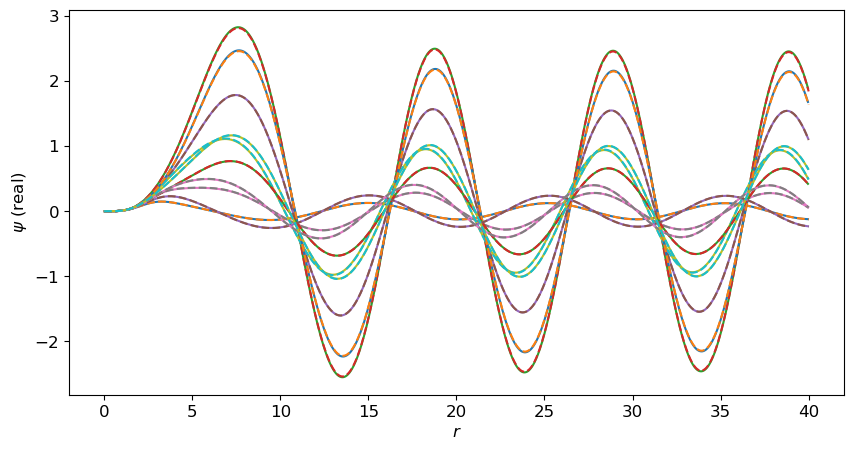

In [106]:
# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(10):
    ax.plot(r[drop:-drop], np.real(emulated_trial1[i][coupled_set_num].get(b_comp[l_val])), zorder=1,label='real')
    ax.plot(r, np.real(a_solutions_rescaled.get(b_comp[l_val])[i]), zorder=1,linestyle='--',label='imag')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$ (real)')
#plt.xlim(0,1)
#ax.set_yscale('log')
pylab.show()